# Data Processing Template
This notebook was used to download, analyze and process the data from the NOAA Pudget Sound dataset.

You can use this template to process your own dataset.

In [1]:
import matplotlib.pyplot as plt
import supervision as sv
from pathlib import Path
import random

## Download the Data
- If you want to use the `unzip` command you might need to install it. On linux, run `sudo apt-get install unzip`

In [2]:
dataset_shortname = "kakadu"
data_dir = Path("/home/giodepe/fish-datasets/data/raw") / dataset_shortname
data_dir.mkdir(exist_ok=True, parents=True)

In [4]:
data = 'https://zenodo.org/record/7250921/files/202210-KakaduFishAI-TrainingData.zip?download=1'
data_path = data_dir / "kakadu_data.zip"

!curl -L '{data}' -o {data_path}
!unzip {data_path} -d {data_dir}
!rm {data_path}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   305  100   305    0     0   1814      0 --:--:-- --:--:-- --:--:--  1815
100 5668M  100 5668M    0     0  7952k      0  0:12:09  0:12:09 --:--:-- 11.1M  2268k      0  0:42:39  0:00:23  0:42:16 2030k3M    0     0  2026k      0  0:47:44  0:01:32  0:46:12 2093k5668M    8  467M    0     0  2121k      0  0:45:35  0:03:45  0:41:50 1960k  16  914M    0     0  3397k      0  0:28:28  0:04:35  0:23:53 10.8M9.9M
Archive:  /home/giodepe/fish-datasets/data/raw/kakadu/kakadu_data.zip
  inflating: /home/giodepe/fish-datasets/data/raw/kakadu/0.jpg  
  inflating: /home/giodepe/fish-datasets/data/raw/kakadu/1.jpg  
  inflating: /home/giodepe/fish-datasets/data/raw/kakadu/10.jpg  
  inflating: /home/giodepe/fish-datasets/data/raw/kakadu/100.jpg  
  inflating: /home/giodepe/fish-datasets/data/raw/kakadu/1000.jpg  
  inflating: /home/giodepe/fis

In [5]:
images_path = data_dir
annotations_path = data_dir / "KakaduFishAI_boundingbox.json"

### Clean the annotations
Turn into COCO format readable by `supervision` library, for easy visualization and conversion to other formats.
- annotations.json only contains annotations for images with at least one bounding box

In [6]:
import json

with open(annotations_path, "r") as f:
    annotations = json.load(f)
    
cleaned_annotations = []
    
print(f"Number of annotations: {len(annotations['annotations'])}")
    
for i, annotation in enumerate(annotations["annotations"]):
    if "bbox" not in annotation or len(annotation["bbox"]) == 0:
        print(f"No bbox found for {annotation['image_id']}")
    else:
        cleaned_annotations.append(annotation)

annotations["annotations"] = cleaned_annotations

with open(annotations_path, "w") as f:
    print(f"Number of annotations: {len(annotations['annotations'])}")
    json.dump(annotations, f)


Number of annotations: 82904
Number of annotations: 82904


## Visualise
To visualise we need to extract the frames from the video, therefore, pick only one video to analyse


In [7]:
dataset = sv.DetectionDataset.from_coco(
    images_directory_path=str(images_path),
    annotations_path=str(annotations_path),
)

print(f"Dataset length: {len(dataset)}")
print(f"Dataset classes: {dataset.classes}")

Dataset length: 44112
Dataset classes: ['Melanotaenia nigrans', 'Oxyeleotris lineolata', 'Glossogobius spp.', 'Glossamia aprion', 'Amniataba percoides', 'Liza ordensis', 'Leiopotherapon unicolor', 'Melanotaenia splendida inornata', 'Toxotes chatareus', 'Scleropages jardinii', 'Nematalosa erebi', 'Neosilurus spp.', 'Lates calcarifer', 'Ambassis agrammus', 'Ambassis macleayi', 'Mogurnda mogurnda', 'Denariusa bandata', 'Sycomistes butleri', 'Craterocephalus sturcusmuscarum', 'Hephaestus fuliginosus', 'Neoarius spp.', 'Strongylura krefftii', 'Megalops cyprinoides']


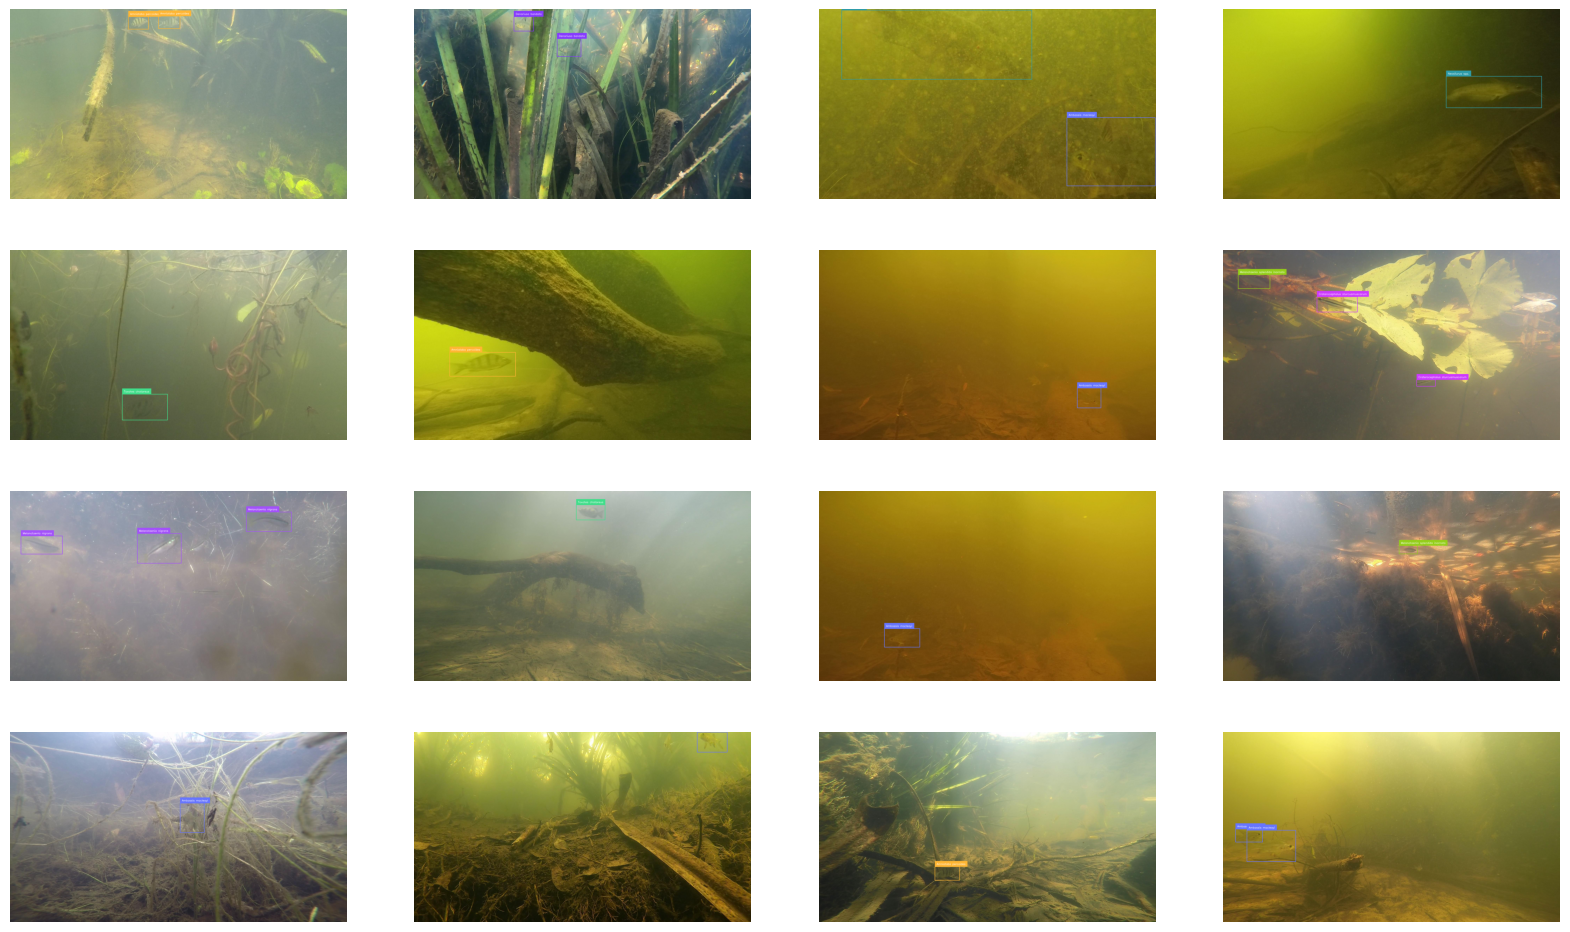

In [8]:
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

image_example = None

annotated_images = []
for _ in range(16):
    i = random.randint(0, len(dataset))
    
    _, image, annotations = dataset[i]

    labels = [dataset.classes[class_id] for class_id in annotations.class_id]

    annotated_image = image.copy()
    annotated_image = box_annotator.annotate(annotated_image, annotations)
    annotated_image = label_annotator.annotate(annotated_image, annotations, labels)
    annotated_images.append(annotated_image)
    
    if len(annotations) > 0:
        image_example = annotated_image
    
sv.plot_images_grid(
    annotated_images,
    grid_size=(4, 4),
    titles=None,
    size=(20, 12),
    cmap="gray"
)

plt.imsave(f"{dataset_shortname}_sample_image.png", image_example)


## Save Output
- Save example image
- Save notebook to visualize the image